# Workshop 2: Connectivity principles and structure function analysis

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
   
<font size=4> The function of the nervous system arises out of a combination of the properties of individual neurons and the properties of how they are connected into a larger network. The central goal of <b>connectomics</b> is to produce complete maps of the connectivity of the nervous system with synaptic resolution and analyze them to better understand the organization, development, and function of the nervous system. </font>

<font size=4><b>Electron Microscopy (EM) data enables morphological reconstruction of neurons and resolution of their synaptic connectivity </b>. The V1DD dataset is one of the largest volume EM datasets currently available, and spans all layers of mouse visual cortex. We will be using this dataset to query the connectivity between neurons in the visual cortex. </font>

<b> The V1DD dataset is newly public. </b> Previous years of this course have used the [MICrONS Dataset](https://www.microns-explorer.org/), which is also a cubic millimeter volume of mouse visual cortex. Both datasets are available for the use of this course, but we will cover V1DD in Week 1.

<h3> Workshop aims</h3>
<ul>
    <li> Understand what are the major classes of cell types in cortex</li>
    <li> Understand the basics of how synaptic connectivity is measured in EM connectomics</li>
    <li> Look at the relationship between the structure of networks and cell type connectivity</li>
    <li> Look at the relationship between functional tuning properties of neurons and how they are connected in the network </li>
</ul>


In this workshop, we explore different two principles that govern how neurons are connected with each other. We will look how

<ol> 
    <li>spatial distance between neurons</li>
    <li>correlation of acitivity traces during specific stimuli </li>
</ol>

are related to neuron-to-neuron connectivity. We will then use the insigts about the relationship between neuron-neuron distance and connectivity to build a new NULL model for the structure-function analysis.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

This cell sets up a variable called `data_root` that generalizes the data directory across systems, whether you are using CodeOcean or the prepared data drives

</div>

In [1]:
import sys
from os.path import join as pjoin
import platform

# Add the directory for the data and utilities
mat_version = 1196

platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS
    data_root = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2025/"

# Set the directory to load prepared data and utility code
data_dir = pjoin(data_root, f"v1dd_{mat_version}")
utils_dir = pjoin("..", "utils")

# Add utilities to path
sys.path.append(utils_dir)

from utils import filter_synapse_table

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Import packages </h2>

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import itertools
from typing import Union, Optional
from scipy import stats, spatial
import itertools
import tqdm
from os.path import join as pjoin
import collections

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Preparation

First, we are loading data files that were introduced in the first workshop such as the synapse and cell tables, and information about proofreading. This workshop does not require the CAVEclient.

In [3]:
# Loads cells with axon and dendrite proofreading
dendrite_proof_root_ids = np.load(pjoin(data_dir, f'proofread_dendrite_list_{mat_version}.npy'))
axon_proof_root_ids = np.load(pjoin(data_dir, f'proofread_axon_list_{mat_version}.npy'))

print(f'There are {len(dendrite_proof_root_ids)} cells with acceptable dendrites, and {len(axon_proof_root_ids)} cells with axon proofreading')
print(f'The number of cells with usable axons and dendrites is: {len(np.isin(axon_proof_root_ids, dendrite_proof_root_ids))}')

There are 63986 cells with acceptable dendrites, and 1210 cells with axon proofreading
The number of cells with usable axons and dendrites is: 1210


In [4]:
syn_df = pd.read_feather(f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather")
cell_df = pd.read_feather(f"{data_dir}/soma_and_cell_type_{mat_version}.feather")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

The cell dataframe contains coordinates for all cells in nanometers. For convenience, we convert those to µm.

In [5]:
cell_df[[col for col in cell_df.columns if "position" in col]] /= 1000.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's remind us of the cell types available to us

In [6]:
cell_df["cell_type"].value_counts()

cell_type
L6-CT    11260
L4-IT     7955
L3-IT     6361
L6-IT     6044
L5-IT     5090
L2-IT     3073
PTC       2951
L5-ET     2013
DTC       1933
ITC       1090
STC        723
L5-NP      699
Name: count, dtype: int64

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## #1: Connection probability vs distance

In this section we will relate connectivity to the distance between two neurons, that is the distance between their soma. We will restrict our analysis to L3-IT pyramidal neurons.

In [7]:
sub_cell_df = cell_df[cell_df["cell_type"] == "L3-IT"]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

The dataset was not imaged in a perfectly upright position. We corrected for that and created the `*trform*` columns for each neuron position. We will use these for our analysis. However, to find neurons in neuroglancer, one has to still use the not-transformed positions.

In [8]:
sub_cell_df.head(5)

,id,pt_position_x,pt_position_y,pt_position_z,pt_position_trform_x,pt_position_trform_y,pt_position_trform_z,pt_root_id,volume,cell_type_coarse,cell_type
2,203262,624.680,531.094,283.770,-252.082628,203.770728,21.544030,864691132654552792,338.276613,E,L3-IT
80,206060,638.648,534.819,413.820,-241.455293,242.581092,150.727000,864691132956447079,304.910673,E,L3-IT
100,427264,1162.836,530.629,283.095,286.300489,200.408581,20.827725,864691132726948075,337.056665,E,L3-IT
176,349313,900.160,569.118,73.305,24.765534,182.277697,-195.233083,864691132717799744,402.068640,E,L3-IT
190,351373,944.314,572.378,210.330,66.224682,222.567876,-57.252409,864691132656979312,277.321739,E,L3-IT


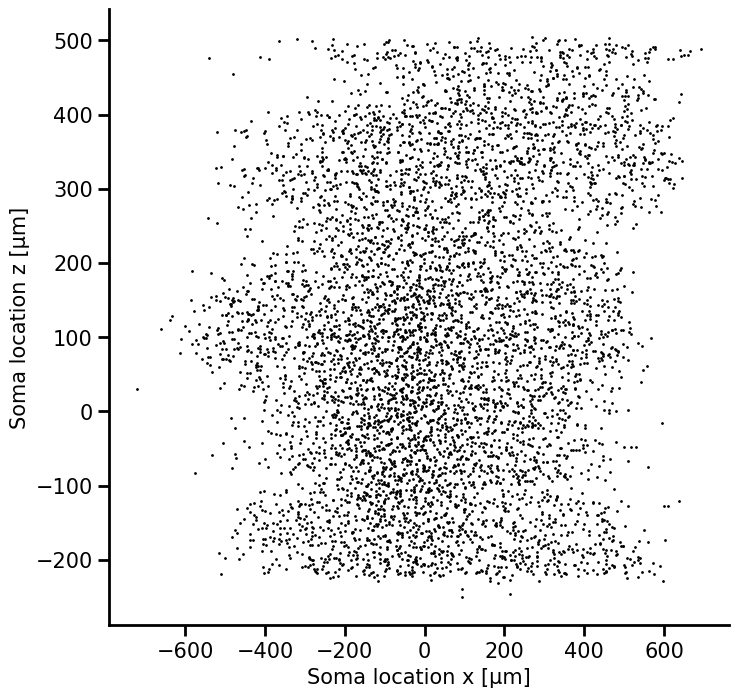

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(data=sub_cell_df, x="pt_position_trform_x", y="pt_position_trform_z", c="k", s=1)

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xlabel("Soma location x [µm]", fontsize=15)
ax.set_ylabel("Soma location z [µm]", fontsize=15)

plt.show()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Task:</b> Are the proofread neurons evenly distributed throughout the dataset? Filter the "sub_cell_df" down to just those cells with proofread axons and plot them on top of the locations of all L3-IT cells.

</div>

In [16]:
# Hint: keep ids that are also in by axon_proof_root_ids
proofread = sub_cell_df[np.isin(sub_cell_df['pt_root_id'], axon_proof_root_ids)]

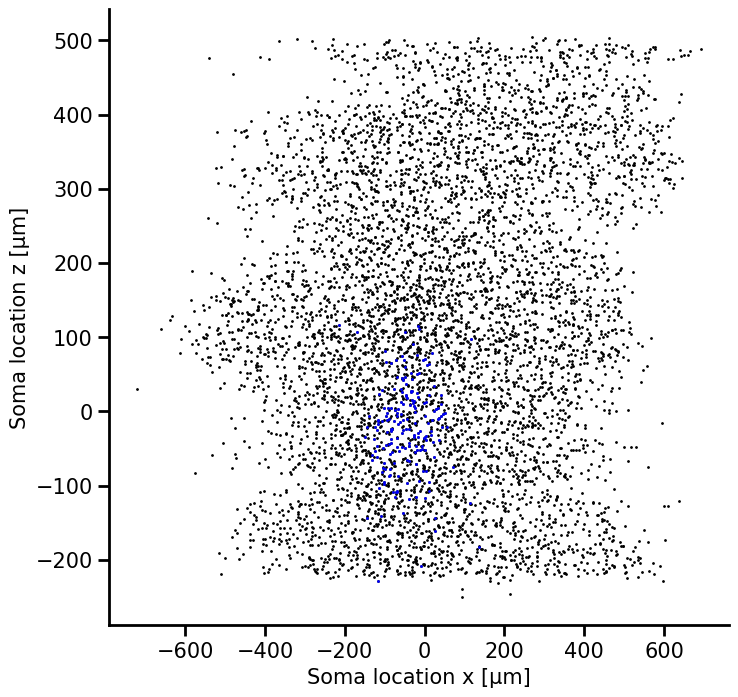

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(data=sub_cell_df, x="pt_position_trform_x", y="pt_position_trform_z", c="k", s=1)
ax.scatter(data=proofread, x="pt_position_trform_x", y="pt_position_trform_z", c="b", s=1)

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xlabel("Soma location x [µm]", fontsize=15)
ax.set_ylabel("Soma location z [µm]", fontsize=15)

plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

To test whether distance and connectedness are correlated, we calculate the _lateral_ distance between pairs of neurons. The _lateral_ distance ignores cortical depth. For a pair of neurons the lateral distance can be calculated as the norm of the difference of their coordinates (in µm):

In [18]:
pos_cols = ["pt_position_trform_x", "pt_position_trform_z"]

difference = sub_cell_df.iloc[0][pos_cols] - sub_cell_df.iloc[1][pos_cols]
np.linalg.norm(difference)

np.float64(129.61936589966894)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

This function computes the lateral distances across all neurons efficiently.

In [19]:
def calculate_lateral_distances(pre_cell_df, post_cell_df=None):
    """ Calculates the lateral distances in µm between all neurons."""
    if post_cell_df is None:
        post_cell_df = pre_cell_df
    
    pre_lateral_locations = np.array(pre_cell_df[["pt_position_trform_x", "pt_position_trform_z"]])
    post_lateral_locations = np.array(post_cell_df[["pt_position_trform_x", "pt_position_trform_z"]])
    lateral_distances = spatial.distance.cdist(pre_lateral_locations, post_lateral_locations)
    
    id_pairs = list(itertools.product(pre_cell_df["pt_root_id"], post_cell_df["pt_root_id"]))
    
    lateral_distance_df = pd.DataFrame(id_pairs, columns=['pre_pt_root_id', 'post_pt_root_id'])
    lateral_distance_df['distance'] = lateral_distances.flatten()

    lateral_distance_df = lateral_distance_df[lateral_distance_df['pre_pt_root_id'] != lateral_distance_df['post_pt_root_id']]
    return lateral_distance_df

In [20]:
# This will take a minute to complete
lateral_distance_df = calculate_lateral_distances(sub_cell_df)
lateral_distance_df.head(5)

,pre_pt_root_id,post_pt_root_id,distance
1,864691132654552792,864691132956447079,129.619366
2,864691132654552792,864691132726948075,538.383594
3,864691132654552792,864691132717799744,351.620849
4,864691132654552792,864691132656979312,327.915267
5,864691132654552792,864691132681577381,594.564370


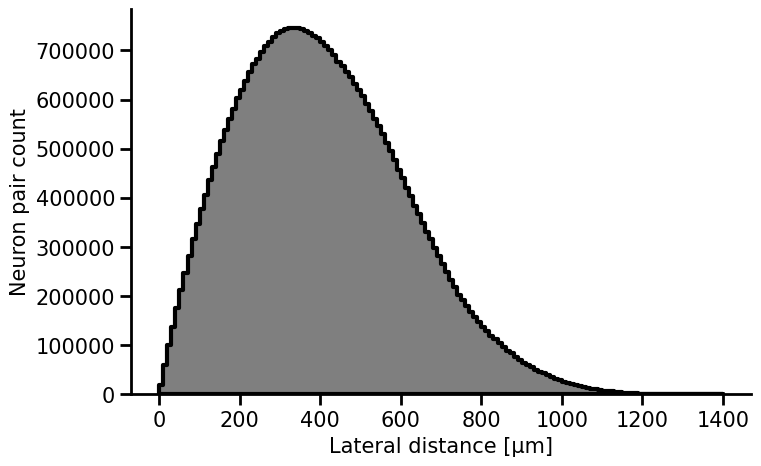

In [21]:
bins = np.linspace(0, 1400, 141)

fig, ax = plt.subplots(figsize=(8, 5))

sns.histplot(lateral_distance_df, x="distance", fill=True, bins=bins, alpha=.5, color="k", lw=3, element="step")

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  

ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 
ax.spines['bottom'].set_linewidth(2)  
ax.spines['left'].set_linewidth(2) 

ax.set_xlabel("Lateral distance [µm]", fontsize=15)
ax.set_ylabel("Neuron pair count", fontsize=15)

plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

This distribution shows the distance between _all pairs_ of L3-IT neurons in the dataset. However, these are not all the pairs for which we can probe connectivity, because not all of them have been proofread. Next, we plot the distances for just the pairs for which we have proofreading information available.

In [22]:
# Gathering proofread L3-IT IDs
pre_root_ids = sub_cell_df["pt_root_id"][np.isin(sub_cell_df["pt_root_id"], axon_proof_root_ids)]
post_root_ids = sub_cell_df["pt_root_id"][np.isin(sub_cell_df["pt_root_id"], dendrite_proof_root_ids)]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Next, we filter the distance dataframe and comparing it to the unfiltered version.

In [23]:
lateral_distance_proofread_df = lateral_distance_df.copy()
lateral_distance_proofread_df = lateral_distance_proofread_df[np.isin(lateral_distance_proofread_df["pre_pt_root_id"], pre_root_ids)]
lateral_distance_proofread_df = lateral_distance_proofread_df[np.isin(lateral_distance_proofread_df["post_pt_root_id"], post_root_ids)]

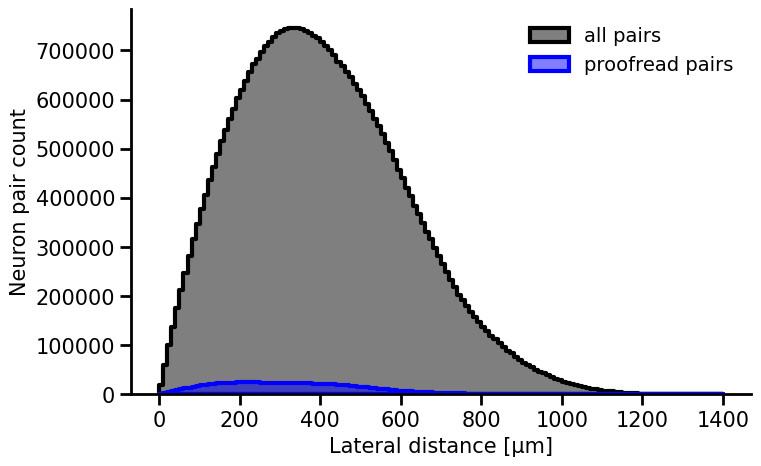

In [26]:
bins = np.linspace(0, 1400, 141)

fig, ax = plt.subplots(figsize=(8, 5))

sns.histplot(lateral_distance_df, x="distance", fill=True, bins=bins, alpha=.5, color="k", lw=3, element="step", label="all pairs")
sns.histplot(lateral_distance_proofread_df, x="distance", fill=True, bins=bins, alpha=.5, color="b", lw=3, element="step", label="proofread pairs")
ax.legend(frameon=False, fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  

ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 
ax.spines['bottom'].set_linewidth(2)  
ax.spines['left'].set_linewidth(2) 

ax.set_xlabel("Lateral distance [µm]", fontsize=15)
ax.set_ylabel("Neuron pair count", fontsize=15)

plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We change to fractions to adjust for the different counts in the populations:

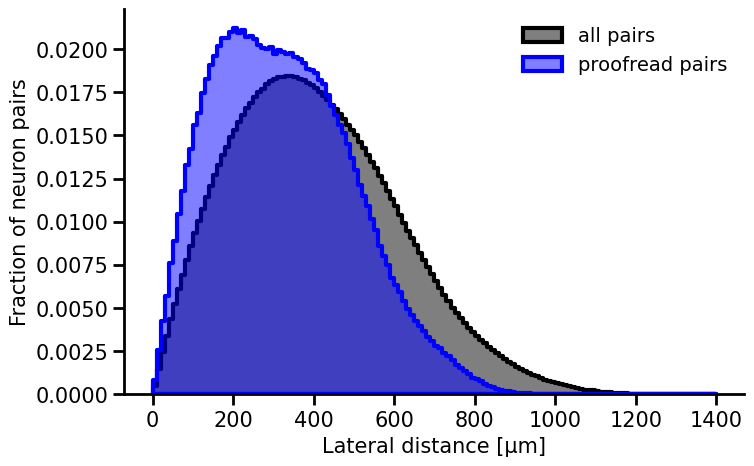

In [27]:
bins = np.linspace(0, 1400, 141)

fig, ax = plt.subplots(figsize=(8, 5))

sns.histplot(lateral_distance_df, stat="proportion", x="distance", fill=True, bins=bins, alpha=.5, color="k", lw=3, element="step", label="all pairs")
sns.histplot(lateral_distance_proofread_df, stat="proportion", x="distance", fill=True, bins=bins, alpha=.5, color="b", lw=3, element="step", label="proofread pairs")
ax.legend(frameon=False, fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  

ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 
ax.spines['bottom'].set_linewidth(2)  
ax.spines['left'].set_linewidth(2) 

ax.set_xlabel("Lateral distance [µm]", fontsize=15)
ax.set_ylabel("Fraction of neuron pairs", fontsize=15)

plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Next, we want to compare this distribution with the distances between the all _connected_ neuron pairs to see if they differ. For that, we filter the synapse table to only include the proofread L3-IT neurons.

In [28]:
analysis_syn_df = filter_synapse_table(syn_df, pre_root_ids, post_root_ids).reset_index(drop=True)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Some neurons are connected with multiple synapses. Here, we will add them together to a single connection.

</div>

In [29]:
conn_df = analysis_syn_df.groupby(["pre_pt_root_id", "post_pt_root_id"])["size"].sum().reset_index()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Finally, we need to combine distance and connectivity information. We have this information in two separate dataframes:

In [30]:
conn_df.head(5)

,pre_pt_root_id,post_pt_root_id,size
0,864691132548503618,864691132543938961,2388
1,864691132548503618,864691132569612060,2471
2,864691132548503618,864691132574630714,3758
3,864691132548503618,864691132578853908,4049
4,864691132548503618,864691132579802898,405


In [31]:
lateral_distance_df.head(5)

,pre_pt_root_id,post_pt_root_id,distance
1,864691132654552792,864691132956447079,129.619366
2,864691132654552792,864691132726948075,538.383594
3,864691132654552792,864691132717799744,351.620849
4,864691132654552792,864691132656979312,327.915267
5,864691132654552792,864691132681577381,594.564370


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Task:</b> For each connection, we would like to know what the distance is between the two neurons. Write the pd.merge function to combine the distance and synapse information of the two tables. Note that the connectivity table has far fewer entries than the distance table. By merging them, we can filter the distance table down to the neuron pairs for which we have a synaptic connection.

Hint: pd.merge can merge on multiple columns at the same. 

</div>

In [32]:
# merge conn_df and lateral_distance_df

conn_dist_df = pd.merge(conn_df, lateral_distance_df, on = ['pre_pt_root_id', 'post_pt_root_id'])

In [33]:
conn_dist_df.shape, conn_df.shape, lateral_distance_df.shape

((9655, 4), (9655, 3), (40455960, 3))

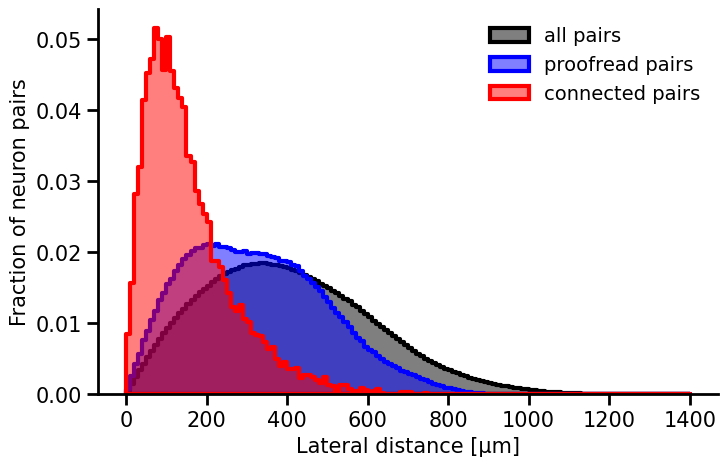

In [36]:
bins = np.linspace(0, 1400, 141)

fig, ax = plt.subplots(figsize=(8, 5))

sns.histplot(lateral_distance_df, stat="proportion", x="distance", fill=True, bins=bins, alpha=.5, color="k", lw=3, element="step", label="all pairs")
sns.histplot(lateral_distance_proofread_df, stat="proportion", x="distance", fill=True, bins=bins, alpha=.5, color="b", lw=3, element="step", label="proofread pairs")
sns.histplot(conn_dist_df, x="distance", stat="proportion", bins=bins, element="step", lw=3, fill=True, alpha=.5, color="r", label="connected pairs")
ax.legend(frameon=False, fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  

ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 
ax.spines['bottom'].set_linewidth(2)  
ax.spines['left'].set_linewidth(2) 

ax.set_xlabel("Lateral distance [µm]", fontsize=15)
ax.set_ylabel("Fraction of neuron pairs", fontsize=15)

plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

To get a better intution, we will look at some examples of connected neuron pairs across distance:

- 10µm: https://spelunker.cave-explorer.org/#!middleauth+https://global.daf-apis.com/nglstate/api/v1/5054147278667776
- 50µm: https://spelunker.cave-explorer.org/#!middleauth+https://global.daf-apis.com/nglstate/api/v1/5895810897149952
- 100µm: https://spelunker.cave-explorer.org/#!middleauth+https://global.daf-apis.com/nglstate/api/v1/5101346838544384
- 500µm: https://spelunker.cave-explorer.org/#!middleauth+https://global.daf-apis.com/nglstate/api/v1/6458760850571264

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Task:</b> Find the synapse between the 500µm-neuron pair.

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Another way to represent the data above is to calculate a "connection probability". That is, <b>how likely is it that two neurons are connected given their lateral distance from each other? </b> 

There are different ways to achieve this, here we will calculate the connection probability for every distance bin.

In [37]:
bins = np.linspace(0, 500, 101) # 5µm bins

# Binned counts for proofread and connected pairs
proofread_pair_counts = np.histogram(lateral_distance_proofread_df["distance"], bins)[0]
connected_pair_counts = np.histogram(conn_dist_df["distance"], bins)[0]

# Fraction of counts between connected and proofread pairs
connection_probability = connected_pair_counts / proofread_pair_counts
connection_probability_df = pd.DataFrame({"bin_id": np.arange(len(bins)-1), "probability": connection_probability})

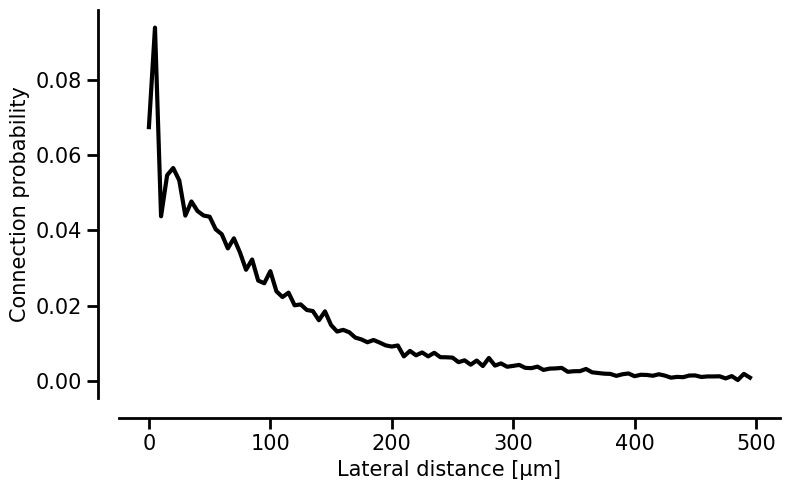

In [38]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(x=bins[:-1], y=connection_probability, lw=3, color="k")

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xlabel("Lateral distance [µm]", fontsize=15)
ax.set_ylabel("Connection probability", fontsize=15)

sns.despine(offset=15, trim=False)
plt.tight_layout()
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## #2: Structure vs function: Connectivity vs activity correlation

The V1dd dataset is a structure function dataset. We have functional measurements for many cells in the datasets. These are very rich and can be related to behavioral data. 

You have seen data access instructions for nwb files previously in this course. For V1DD, see data instructions in the databook:

<font size=4> <a href=https://allenswdb.github.io/physiology/ophys/V1DD/V1DD-overview.html> V1 Deep Dive Overview </a> </font>

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<b>Activity correlations</b> For the purpose of this workshop, we precalculated correlations between cells. To be more precise, we calculated the total correlation of the activity traces of neurons imaged during the same session during the same stimulus condition.

If you want to use the V1dd dataset for a project, this kind of analysis could be extended to include behavioral data and create more sophisticated functional comparisons between cells which can then be related to the connectivity data.

<b>Coregistration</b>: To analyze the functional and connectivity data, neurons in both datasets need to be _coregistered_, that is an ROI in the activity stack needs to be linked with a cell body in the EM stack. The data below only contains those neurons which were coregistered.

In [39]:
corr_coreg_df = pd.read_feather(f"{data_dir}/cell_cell_correlations_by_stimulus_coregistered.feather")

In [40]:
corr_coreg_df.head(5)

,pre_pt_root_id,post_pt_root_id,drifting_gratings_full,drifting_gratings_windowed,locally_sparse_noise,natural_images,natural_images_12,natural_movie,spontaneous
0,864691132631872354,864691132993747701,0.050142,0.027819,0.154472,0.181724,0.158909,0.004957,0.078471
1,864691132631872354,864691132786447756,0.055267,0.018284,0.119418,0.115587,0.124021,0.010296,0.197349
2,864691132631872354,864691132617961537,0.065444,0.062367,0.143660,0.065078,0.073297,0.053197,0.108968
3,864691132631872354,864691132758875499,0.075457,0.039646,0.057388,0.123202,0.026544,0.025227,0.027960
4,864691132631872354,864691132897987302,0.076981,0.053317,0.107852,0.134347,0.105139,0.022267,0.050300


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Correlations of activity traces for different stimulus conditions are available to us.

In [42]:
stimulus_conditions = corr_coreg_df.columns[2:]
stimulus_conditions

Index(['drifting_gratings_full', 'drifting_gratings_windowed',
       'locally_sparse_noise', 'natural_images', 'natural_images_12',
       'natural_movie', 'spontaneous'],
      dtype='object')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Can we treat the different stimulus conditions as separate experiments or would we expect all results to be similar no matter what stimulus condition we base or analysis on? Next, we analyze how correlated the co-activities of cells are between the different stimulus conditions. For that, we calculate the correlation of the pairwise correlations. 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Discussion:</b> What outcome do you expect and what do different results mean for the use of the neuron-neuron correlations for further analysis?

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We use pandas [corr](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) function to correlated all pairs of stimulus condition columns:

In [43]:
stim_stim_corr_df = corr_coreg_df[stimulus_conditions].corr()
stim_stim_corr_df

,drifting_gratings_full,drifting_gratings_windowed,locally_sparse_noise,natural_images,natural_images_12,natural_movie,spontaneous
drifting_gratings_full,1.000000,0.346590,0.254331,0.250694,0.134864,0.185345,0.153530
drifting_gratings_windowed,0.346590,1.000000,0.166516,0.261764,0.122732,0.210057,0.116764
locally_sparse_noise,0.254331,0.166516,1.000000,0.382013,0.218488,0.240477,0.222442
natural_images,0.250694,0.261764,0.382013,1.000000,0.220889,0.181255,0.178556
natural_images_12,0.134864,0.122732,0.218488,0.220889,1.000000,0.121014,0.139444
natural_movie,0.185345,0.210057,0.240477,0.181255,0.121014,1.000000,0.167174
spontaneous,0.153530,0.116764,0.222442,0.178556,0.139444,0.167174,1.000000


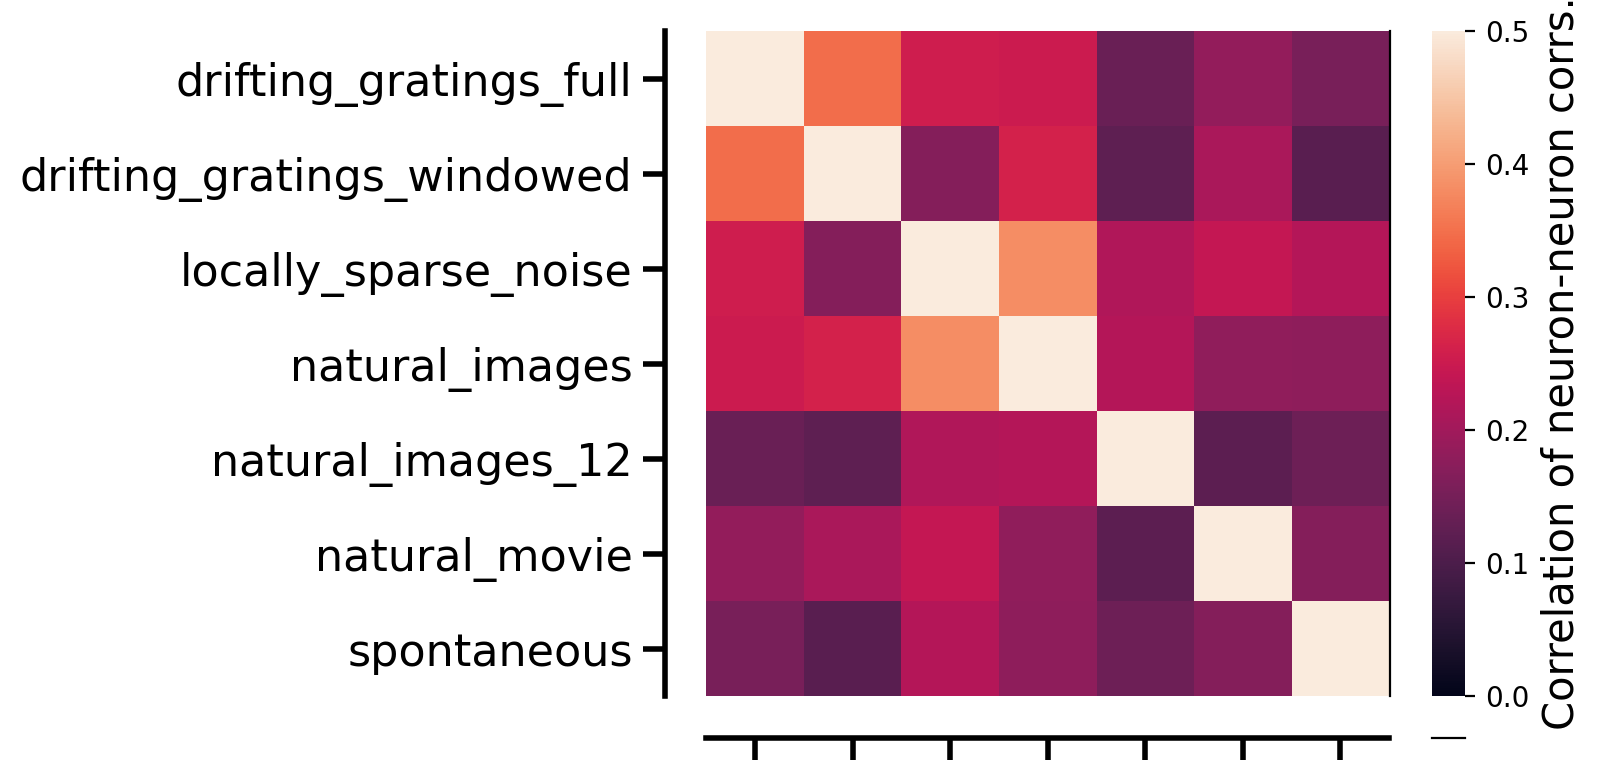

In [44]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=200)

heatmap = sns.heatmap(stim_stim_corr_df, ax=ax, vmax=.5, vmin=0)
colorbar = heatmap.collections[0].colorbar
colorbar.set_label("Correlation of neuron-neuron corrs.", fontsize=15)

ax.tick_params(axis='both', which='major', labelsize=16, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xticklabels([])
ax.set_xlabel("")
ax.set_ylabel("")
sns.despine(offset=15, trim=False)
plt.tight_layout()
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Another way to compare the different stimulus conditions is to plot the distributions of the neuron-neuron correlations.

In [47]:
stimulus_conditions

Index(['drifting_gratings_full', 'drifting_gratings_windowed',
       'locally_sparse_noise', 'natural_images', 'natural_images_12',
       'natural_movie', 'spontaneous'],
      dtype='object')

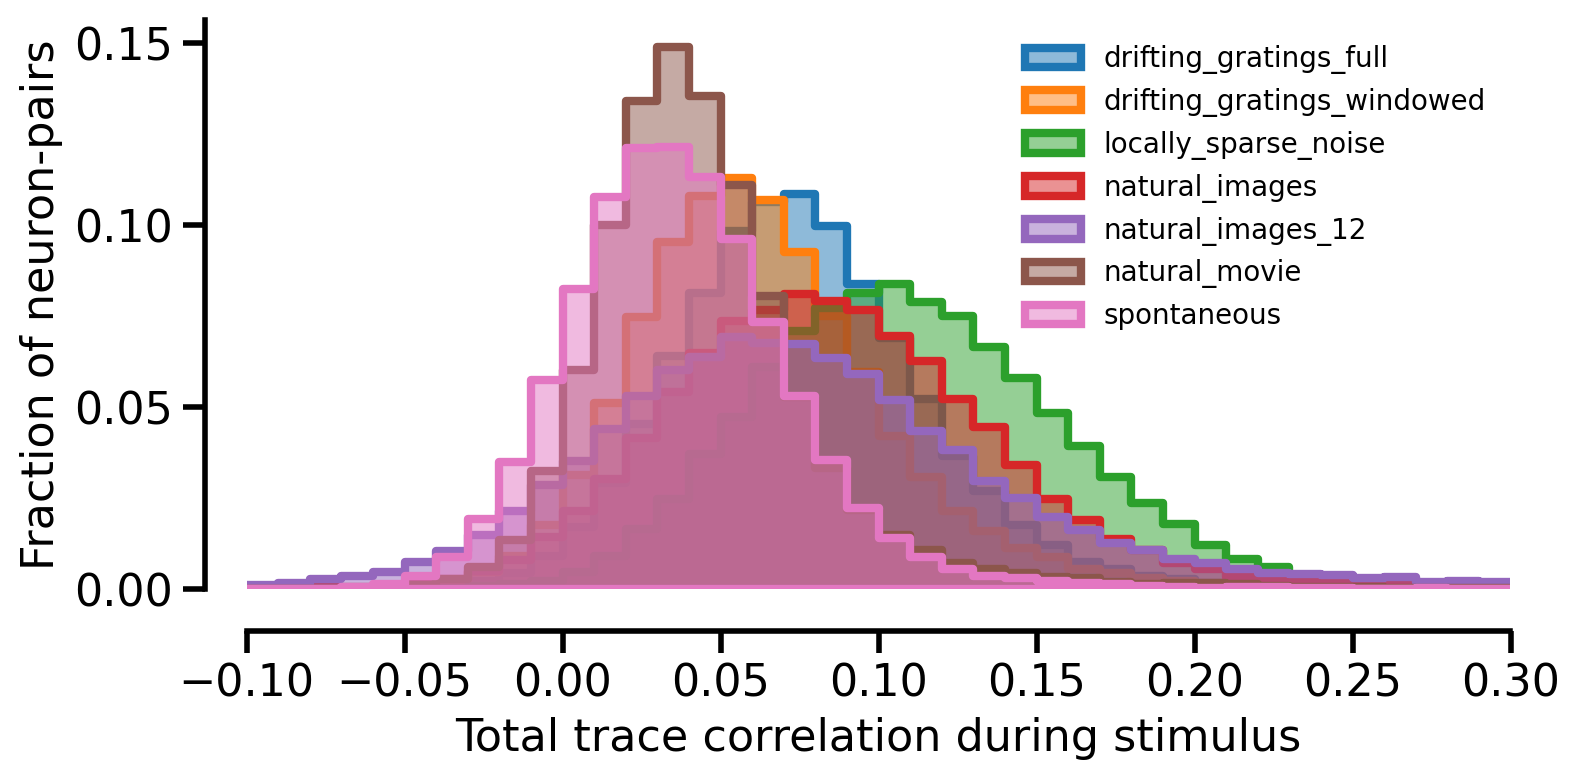

In [49]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=200)

for stim in stimulus_conditions:
    sns.histplot(data=corr_coreg_df, x=stim, label=stim, bins=np.linspace(-1, 1, 201), 
             element="step", lw=3, ax=ax, stat="probability", alpha=.5)

ax.legend(frameon=False)
ax.tick_params(axis='both', which='major', labelsize=16, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine
ax.set_xlim(-.1, .3)

ax.set_xlabel("Total trace correlation during stimulus", fontsize=16)
ax.set_ylabel("Fraction of neuron-pairs", fontsize=16)
sns.despine(offset=15, trim=False)
plt.tight_layout()
plt.show()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Task:</b> Add the distributions for the other stimulus conditions into the same plot.

</div>

In [ ]:
# Plot for stim in stimulus_conditions

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

With the activity correlation between neurons in hand, we want to answer one question: <b>Are neurons that are more correlated in their activity, more likely to be connected with each other?</b>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

As before, we will limit this analysis to L3-IT neurons. We collect the connectivity information between these neurons as before.

In [50]:
sub_cell_df = cell_df[cell_df["cell_type"] == "L3-IT"]

In [51]:
pre_root_ids = sub_cell_df["pt_root_id"][np.isin(sub_cell_df["pt_root_id"], axon_proof_root_ids)]
post_root_ids = sub_cell_df["pt_root_id"][np.isin(sub_cell_df["pt_root_id"], dendrite_proof_root_ids)]

In [52]:
analysis_syn_df = filter_synapse_table(syn_df, axon_proof_root_ids, dendrite_proof_root_ids).reset_index(drop=True)
conn_df = analysis_syn_df.groupby(["pre_pt_root_id", "post_pt_root_id"])["size"].sum().reset_index()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We will limit our analysis to just those neurons for which we have proofreading data available

In [53]:
corr_coreg_proofread_df = corr_coreg_df.copy()
corr_coreg_proofread_df = corr_coreg_proofread_df[np.isin(corr_coreg_proofread_df["pre_pt_root_id"], pre_root_ids)]
corr_coreg_proofread_df = corr_coreg_proofread_df[np.isin(corr_coreg_proofread_df["post_pt_root_id"], post_root_ids)]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's compare the connectivity and the activity correlation data.

In [54]:
conn_corr_df = pd.merge(conn_df, corr_coreg_proofread_df, on=["pre_pt_root_id", "post_pt_root_id"])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

These are the numbers of neuron pairs we have available for our comparison:

In [55]:
corr_coreg_proofread_df.shape, conn_corr_df.shape

((13542, 9), (331, 10))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

For a given stimulus, we compare the distributions of activity correlations between the connected pairs with the activity correlations of all pairs.

In [74]:
# Select a stimulus condition to plot
stim = stimulus_conditions[4]
stim

'natural_images_12'

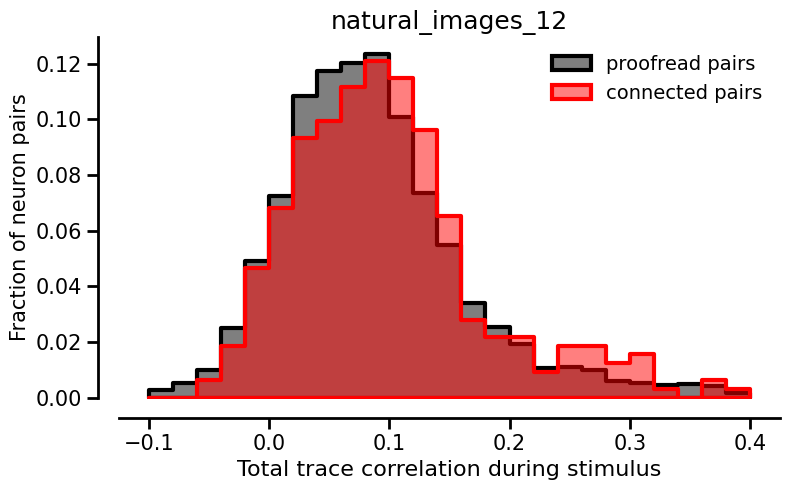

In [75]:
bins=np.linspace(-.1, .4, 26)

fig, ax = plt.subplots(figsize=(8, 5))

ax.set_title(stim, fontsize=18)

sns.histplot(corr_coreg_proofread_df, x=stim, stat="probability", bins=bins, element="step", label="proofread pairs", lw=3, fill=True, alpha=.5, color="k")
sns.histplot(conn_corr_df, x=stim, stat="probability", bins=bins, element="step", label="connected pairs", lw=3, fill=True, alpha=.5, color="r")

ax.legend(frameon=False, fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xlabel("Total trace correlation during stimulus", fontsize=16)
ax.set_ylabel("Fraction of neuron pairs", fontsize=15)
sns.despine(offset=15, trim=False)
plt.tight_layout()

plt.show()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Task:</b> Repeat the plot above for different stimulus conditions. Do they all show similar results?

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Just like for the distance analysis above (#1), we can express this result as a "connection probability" for a given correlation. That is, how likely is it that two neurons are connected given their activity correlation? 

Here, we will calculate the connection probability bins of activity correlations. We use percentile bins to avoid having to pick suitable bin locations.

In [76]:
bins = np.percentile(corr_coreg_proofread_df[stim], np.linspace(0, 100, 6)) # Makes 5 bins
bin_centers = np.convolve(bins, [.5, .5], mode="valid") # Calulates the center of each bin

# Counts for proofread and connected pairs
proofread_pair_counts = np.histogram(corr_coreg_proofread_df[stim], bins)[0]
connected_pair_counts = np.histogram(conn_corr_df[stim], bins)[0]

# Fraction of counts between connected and proofread pairs
connection_probability = connected_pair_counts / (proofread_pair_counts + 1e-6)

/tmp/ipykernel_109/2033719600.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False, fontsize=14)


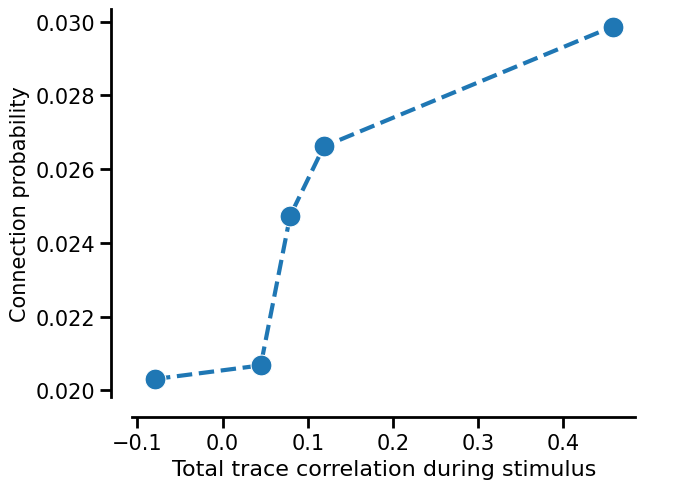

In [77]:
fig, ax = plt.subplots(figsize=(7, 5))

sns.lineplot(x=bin_centers, y=connection_probability, lw=3, ls="--", legend=False, ax=ax, marker="o", markersize=15)

ax.legend(frameon=False, fontsize=14)
ax.get_legend().set_bbox_to_anchor([1.1, 1])
ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xlabel("Total trace correlation during stimulus", fontsize=16)
ax.set_ylabel("Connection probability", fontsize=15)

sns.despine(offset=15, trim=False)
plt.tight_layout()
plt.show()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Task:</b> Add the distributions for the other stimulus conditions into the same plot.

</div>

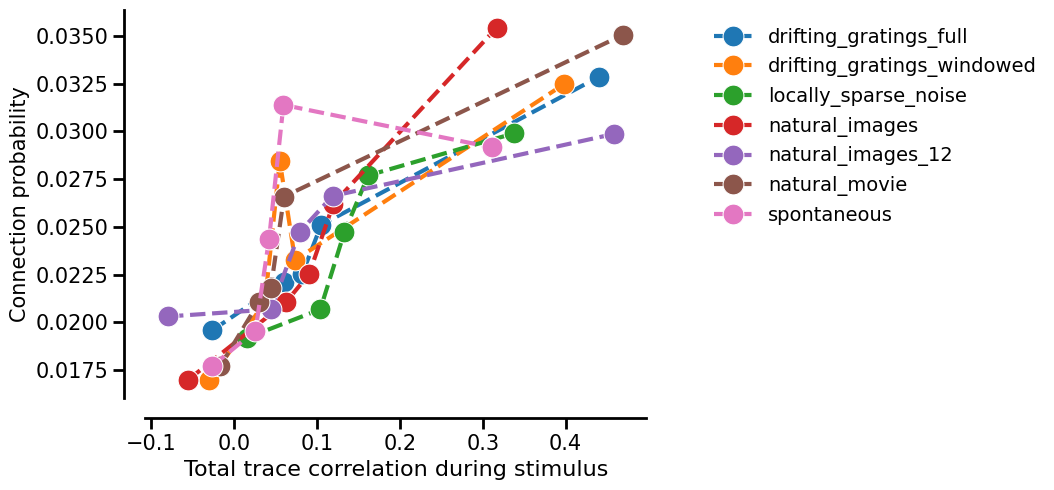

In [78]:
# Plot for stim in stimulus_conditions

# Solution
fig, ax = plt.subplots(figsize=(11, 5))

for stim in stimulus_conditions:
    bins = np.percentile(corr_coreg_proofread_df[stim], np.linspace(0, 100, 6))#[[0, 1, -2, -1]]

    bin_centers = np.convolve(bins, [.5, .5], mode="valid")#[[0, -1]]
    proofread_pair_counts = np.histogram(corr_coreg_proofread_df[stim], bins)[0]#[[0, -1]]
    connected_pair_counts = np.histogram(conn_corr_df[stim], bins)[0]#[[0, -1]]
    
    connection_probability = connected_pair_counts / (proofread_pair_counts + 1e-6)
    
    sns.lineplot(x=bin_centers, y=connection_probability, lw=3, ls="--", label=stim, legend=False, ax=ax, marker="o", markersize=15)

ax.legend(frameon=False, fontsize=14)
ax.get_legend().set_bbox_to_anchor([1.1, 1])
ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xlabel("Total trace correlation during stimulus", fontsize=16)
ax.set_ylabel("Connection probability", fontsize=15)

sns.despine(offset=15, trim=False)
plt.tight_layout()
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Summary

We showed that for L3-IT cells

1. neurons that are closer to each other, are more likely to be connected.
2. neurons with more correlated activity traces, are more likely to be connected.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## A stronger NULL model: Can distance $\rightarrow$ connectivity account for structure-function correlation

So far we implicity used a _NULL model_ where all neuron pairs have the same likelihood to be connected. But we just showed that spatial separation alone increases the probability that two neurons are connected. Can this account for the correlation between activity correlation and connectivity?

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Discuss:</b> How could we implement such a NULL model?

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<b>Collecting data products:</b> We will create a single dataframe that contains all information about the proofread, coregistered pairs: Their distance, their activity correlations, whether they are connected. Let's port the results from our previous analyses

In [79]:
# Select one subtype of cell
sub_cell_df = cell_df[cell_df["cell_type"] == "L3-IT"]

pre_root_ids = sub_cell_df["pt_root_id"][np.isin(sub_cell_df["pt_root_id"], axon_proof_root_ids)]
post_root_ids = sub_cell_df["pt_root_id"][np.isin(sub_cell_df["pt_root_id"], dendrite_proof_root_ids)]

In [80]:
# Connectivity analaysis

analysis_syn_df = filter_synapse_table(syn_df, axon_proof_root_ids, dendrite_proof_root_ids).reset_index(drop=True)
conn_df = analysis_syn_df.groupby(["pre_pt_root_id", "post_pt_root_id"])["size"].sum().reset_index()

In [81]:
# Distance analysis

lateral_distance_df = calculate_lateral_distances(sub_cell_df)

lateral_distance_proofread_df = lateral_distance_df.copy()
lateral_distance_proofread_df = lateral_distance_proofread_df[np.isin(lateral_distance_proofread_df["pre_pt_root_id"], pre_root_ids)]
lateral_distance_proofread_df = lateral_distance_proofread_df[np.isin(lateral_distance_proofread_df["post_pt_root_id"], post_root_ids)]

In [82]:
# Activity correlation

corr_coreg_proofread_df = corr_coreg_df.copy()
corr_coreg_proofread_df = corr_coreg_proofread_df[np.isin(corr_coreg_proofread_df["pre_pt_root_id"], pre_root_ids)]
corr_coreg_proofread_df = corr_coreg_proofread_df[np.isin(corr_coreg_proofread_df["post_pt_root_id"], post_root_ids)]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

**Combine data products**: Let's combine our main three dataframes into one. We are merging the dataframes together, in a way that retains all entries in "corr_coreg_proofread_df". 

In [83]:
# set 'corr_coreg_proofread_df' as the base dataframe to merge to
full_df = corr_coreg_proofread_df.copy()

# merge the lateral distance 
full_df = pd.merge(full_df, lateral_distance_proofread_df, on=["pre_pt_root_id", "post_pt_root_id"])

# merge the connectivity, setting empty entries to 0
full_df = pd.merge(full_df, conn_df, on=["pre_pt_root_id", "post_pt_root_id"], how="left").fillna(0)

In [84]:
full_df["connected"] = np.array(full_df["size"] > 0)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<b>Measurement:</b> We will summarize the structure-function result with one value, the mean correlation of the cells in the connected and overall group.

In [85]:
full_df.groupby("connected")[stimulus_conditions].mean()

,drifting_gratings_full,drifting_gratings_windowed,locally_sparse_noise,natural_images,natural_images_12,natural_movie,spontaneous
connected,,,,,,,
False,0.084353,0.057491,0.132732,0.092382,0.092694,0.049225,0.044221
True,0.095569,0.066407,0.142196,0.108888,0.110299,0.060519,0.050646


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<b>Distance-based null model to sample connectomes:</b> Instead of using the not-connected neurons as our NULL model for comparison, we want to use our insight about the connection probabilities vs neuron distance to create a stronger NULL model. We will achieve this by sampling new "connectomes" based on the distance-based connection probabilities. For each new connectome, we will calculate the correlation of the connected (sampled) neurons.

First, we assign probabilities to each potential connection by recreating the connection probability measurements from #1:

In [86]:
conn_dist_df = pd.merge(conn_df, lateral_distance_df, on=["pre_pt_root_id", "post_pt_root_id"])

In [87]:
# Distance vs Connectivity
distance_bins = np.linspace(0, 500, 101)

proofread_pair_counts = np.histogram(lateral_distance_proofread_df["distance"], distance_bins)[0]
connected_pair_counts = np.histogram(conn_dist_df["distance"], distance_bins)[0]

connection_probability = connected_pair_counts / proofread_pair_counts
connection_probability_df = pd.DataFrame({"bin_id": np.arange(len(distance_bins)-1), "bin_start": distance_bins[:-1], "bin_end": distance_bins[1:], "connection_probability": connection_probability})

In [88]:
connection_probability_df.head(5)

,bin_id,bin_start,bin_end,connection_probability
0,0,0.0,5.0,0.067376
1,1,5.0,10.0,0.093750
2,2,10.0,15.0,0.043745
3,3,15.0,20.0,0.054633
4,4,20.0,25.0,0.056544


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Finally, we assign each neuron-neuron pair their probability to be connected based on their distance. "np.digitize" allows us to assign each pair to a bin, which we then use to combine the "full_df" with the connection probability dataframe.

In [89]:
full_df["bin_id"] = np.digitize(full_df["distance"], distance_bins)
full_df = pd.merge(full_df, connection_probability_df, on="bin_id")

In [90]:
full_df.head(5)

,pre_pt_root_id,post_pt_root_id,drifting_gratings_full,drifting_gratings_windowed,locally_sparse_noise,natural_images,natural_images_12,natural_movie,spontaneous,distance,size,connected,bin_id,bin_start,bin_end,connection_probability
0,864691132993747701,864691132631872354,0.050142,0.027819,0.154472,0.181724,0.158909,0.004957,0.078471,85.151632,0.0,False,18,90.0,95.0,0.026708
1,864691132993747701,864691132617961537,0.011712,-0.018059,0.177509,0.053082,0.118612,0.053856,0.061307,91.486300,0.0,False,19,95.0,100.0,0.026004
2,864691132993747701,864691132758875499,0.054421,0.014667,0.100715,0.112722,0.078214,0.030832,0.059752,280.780633,0.0,False,57,285.0,290.0,0.004177
3,864691132993747701,864691132897987302,0.046524,0.035209,0.127884,0.123014,0.054419,0.017720,0.062639,101.529102,0.0,False,21,105.0,110.0,0.023876
4,864691132993747701,864691132788044746,0.055996,0.032199,0.157370,0.151779,0.161101,0.037326,0.008181,178.220574,0.0,False,36,180.0,185.0,0.010358


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<b>Task:</b> Sampling connectomes. Sample a connectome using  [np.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html). This function takes a list of entries ("a"), their sampling probabilities which have to sum to one as input ("p"), and a number of samples that should be taken ("size").

</div>

In [96]:
full_df['bin_id'].unique()

array([18, 19, 57, 21, 36, 15, 28, 24, 23, 49, 31, 12, 34, 39, 11, 40, 14,
        5, 46, 35, 29, 32, 55, 16, 22, 38, 41, 53, 25,  9, 43,  3, 50,  6,
       44, 13, 20, 47,  8, 33, 27, 51, 17, 10, 48, 52, 45, 42, 37,  7, 30,
       54, 58, 26, 60,  4,  2, 62, 63,  1, 59, 61, 56, 65, 68, 74, 70, 64,
       67, 69, 73, 72])

In [100]:
#full_df[['bin_id', 'connection_probability']].groupby('bin_id').sum()

In [102]:
full_sampled_df = full_df.copy()
sampled_idx = np.random.choice(a=np.arange(len(full_df)) , size=np.sum(full_sampled_df['connected']) , replace=False, p=full_df['connection_probability']/full_df['connection_probability'].sum())

full_sampled_df["connected_sampled"] = False
full_sampled_df.loc[sampled_idx, "connected_sampled"] = True

full_sampled_df.loc[sampled_idx]

,pre_pt_root_id,post_pt_root_id,drifting_gratings_full,drifting_gratings_windowed,locally_sparse_noise,natural_images,natural_images_12,natural_movie,spontaneous,distance,size,connected,bin_id,bin_start,bin_end,connection_probability,connected_sampled
490,864691132681691705,864691132738257819,0.108044,0.029568,0.189263,0.108072,0.513797,0.132499,0.006261,53.493616,0.0,False,11,55.0,60.0,0.040305,True
4868,864691132771662867,864691132678138963,0.093435,0.112272,0.132317,0.111364,-0.001883,0.046434,0.040611,141.696349,0.0,False,29,145.0,150.0,0.018550,True
4263,864691132741590308,864691132830842994,0.084791,0.039629,0.174337,0.008299,0.179190,0.065999,0.053407,98.516686,0.0,False,20,100.0,105.0,0.029198,True
8446,864691132834925960,864691132685014724,0.140086,0.129450,0.221452,0.217120,0.250981,0.102259,0.026511,52.158171,0.0,False,11,55.0,60.0,0.040305,True
924,864691132718745563,864691132635612967,0.059118,0.084188,0.125011,0.101365,0.085140,0.035881,0.024705,114.721598,0.0,False,23,115.0,120.0,0.023510,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5571,864691132828651313,864691132728052910,0.098545,0.034924,0.158567,0.161040,0.083102,0.030919,0.039227,124.899545,0.0,False,25,125.0,130.0,0.020391,True
8497,864691132595467831,864691132830842994,0.122131,0.054605,0.075298,0.011204,0.343281,0.042353,0.081501,49.143166,0.0,False,10,50.0,55.0,0.043637,True
7669,864691132660826793,864691132895044054,0.108724,0.045464,0.216086,0.065405,0.144347,0.003373,0.082796,94.934796,0.0,False,19,95.0,100.0,0.026004,True
9673,864691132972662837,864691132777104032,0.021303,0.026184,0.218339,0.031024,0.047717,0.003160,0.020066,76.097461,0.0,False,16,80.0,85.0,0.029577,True


In [103]:
full_sampled_df.groupby("connected_sampled")[stimulus_conditions].mean()

,drifting_gratings_full,drifting_gratings_windowed,locally_sparse_noise,natural_images,natural_images_12,natural_movie,spontaneous
connected_sampled,,,,,,,
False,0.084556,0.057625,0.132724,0.092771,0.092769,0.049361,0.044267
True,0.087458,0.061037,0.142500,0.093390,0.107300,0.055079,0.048805


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We repeat the sampling 10,000 times and combine the result in a DataFrame.

In [104]:
sampled_means = []

for _ in tqdm.tqdm(range(10_000)):
    full_sampled_df = full_df.copy()
    sampled_idx = np.random.choice(
        full_sampled_df.index,
        p=full_sampled_df["connection_probability"] / full_sampled_df["connection_probability"].sum(),
        size=np.sum(full_sampled_df["connected"])
    )
    
    full_sampled_df["connected_sampled"] = False
    full_sampled_df.loc[sampled_idx, "connected_sampled"] = True
    
    means = full_sampled_df.loc[full_sampled_df["connected_sampled"], stimulus_conditions].mean()
    sampled_means.append(means)

# Combine into a DataFrame (each row = one sample)
sampled_means_df = pd.DataFrame(sampled_means)

100%|██████████| 10000/10000 [00:27<00:00, 359.85it/s]


In [128]:
sampled_means_df.head(5)

,drifting_gratings_full,drifting_gratings_windowed,locally_sparse_noise,natural_images,natural_images_12,natural_movie,spontaneous
0,0.087623,0.058203,0.137207,0.100131,0.105680,0.050865,0.045914
1,0.088385,0.059400,0.138158,0.095401,0.101909,0.054932,0.045536
2,0.090353,0.065735,0.138512,0.096646,0.099654,0.052678,0.047930
3,0.087057,0.058104,0.135837,0.094049,0.101525,0.051792,0.043131
4,0.090014,0.059531,0.132953,0.090564,0.103599,0.053417,0.044329


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

With the results in hand, lets plot our distribution for a single stimulus condition.

In [145]:
stim = stimulus_conditions[3]
stim

'natural_images'

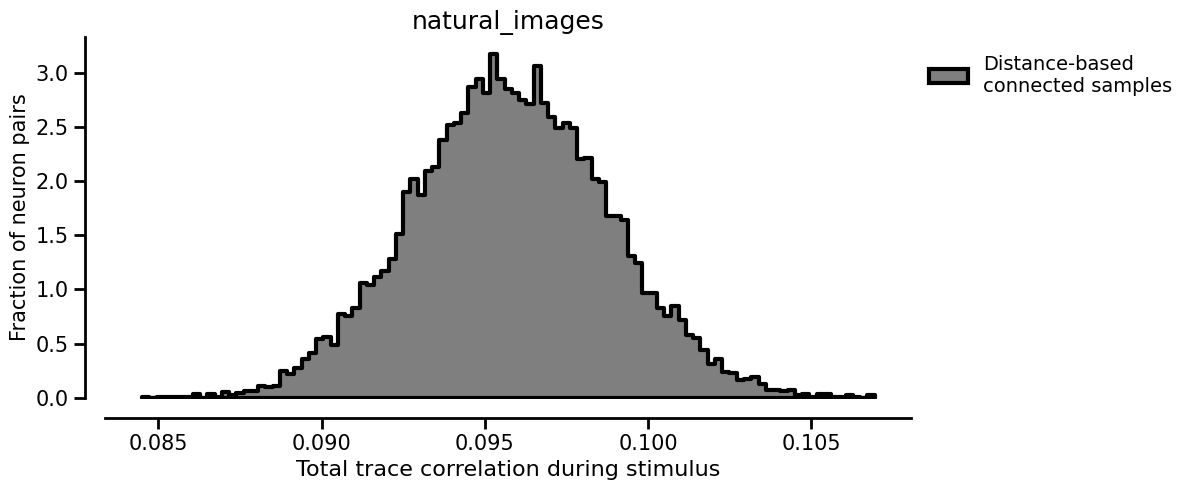

In [146]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.set_title(stim, fontsize=18)

sns.histplot(data=sampled_means_df, x=stim, stat="percent", bins=101, element="step", label="Distance-based\nconnected samples", 
             lw=3, fill=True, alpha=.5, color="k")

ax.legend(frameon=False, fontsize=14, bbox_to_anchor=[1, 1], loc="upper left")

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xlabel("Total trace correlation during stimulus", fontsize=16)
ax.set_ylabel("Fraction of neuron pairs", fontsize=15)
sns.despine(offset=15, trim=False)
plt.tight_layout()

plt.show()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Task:</b> How different is our distribution from the observed correlation of the connected neurons? Calculate the Z-Score between the observed result and the measured correlation of the connected neurons. Use df.mean() and df.std().

</div>

In [147]:
observed_stim_means = full_df[full_df["connected"]][stimulus_conditions].mean()

# calculate z scores: using df.mean() and df.std()

In [148]:
zscores = (observed_stim_means - sampled_means_df.mean()) / sampled_means_df.std()

In [149]:
zscores

drifting_gratings_full        2.614488
drifting_gratings_windowed    2.911897
locally_sparse_noise          1.581242
natural_images                4.367453
natural_images_12             1.731897
natural_movie                 3.707263
spontaneous                   1.941206
dtype: float64

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Visualizing it all in one plot:

In [150]:
stim = stimulus_conditions[3]
stim

'natural_images'

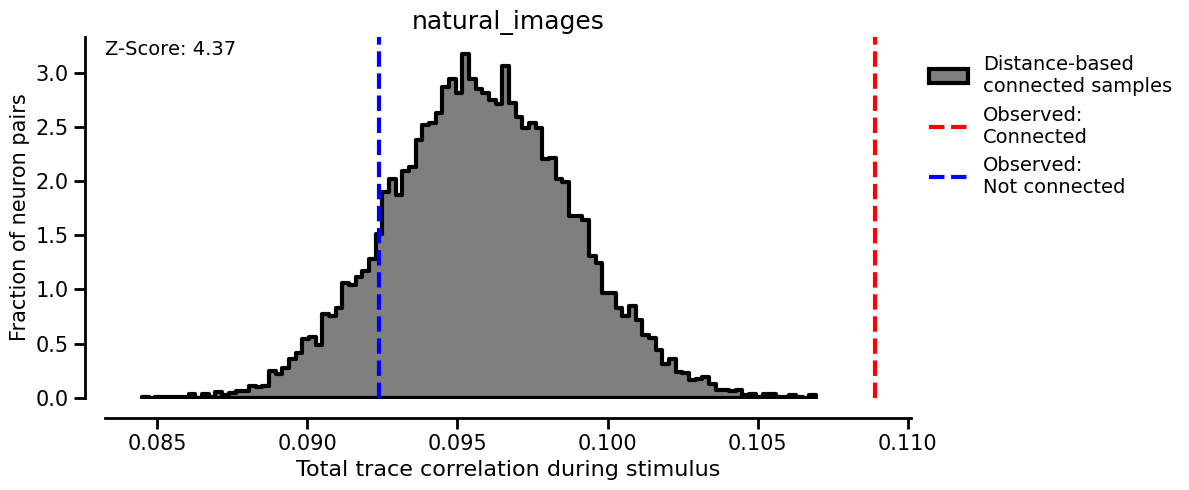

In [151]:
zscore = (full_df[full_df["connected"]][stim].mean() - sampled_means_df[stim].mean()) / sampled_means_df[stim].std()

fig, ax = plt.subplots(figsize=(12, 5))

ax.set_title(stim, fontsize=18)

sns.histplot(data=sampled_means_df, x=stim, stat="percent", bins=101, element="step", label="Distance-based\nconnected samples", 
             lw=3, fill=True, alpha=.5, color="k")

ax.axvline(x=full_df[full_df["connected"]][stim].mean(), color='r', linestyle='--', label='Observed:\nConnected', lw=3)
ax.axvline(x=full_df[~full_df["connected"]][stim].mean(), color='b', linestyle='--', label='Observed:\nNot connected', lw=3)

ax.text(ax.get_xlim()[0], ax.get_ylim()[1] * .95, f"Z-Score: {zscore:.2f}", fontsize=14)
ax.legend(frameon=False, fontsize=14, bbox_to_anchor=[1, 1], loc="upper left")

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xlabel("Total trace correlation during stimulus", fontsize=16)
ax.set_ylabel("Fraction of neuron pairs", fontsize=15)
sns.despine(offset=15, trim=False)
plt.tight_layout()

plt.show()